In [22]:
%matplotlib inline

In [ ]:
import numpy as np
from scipy.stats import vonmises
from scipy.ndimage import convolve
from thllib import flylib
from matplotlib import pyplot as plt

fly = flylib.NetFly(1333)

fly.open_signals('hdf5')

angles = np.linspace(0,360,360*2)[:-1]

vel_kappa = 0.5 #vonmises kappa applied to velocity prediction in baysian filter, higher values will favor slow transitions.
state_kappa = 0.01

vel_kernel = vonmises.pdf(np.deg2rad(angles)-np.pi,vel_kappa)
vel_kernel /= np.sum(vel_kernel)
state_kernel = vonmises.pdf(np.deg2rad(angles)-np.pi,state_kappa)
state_kernel /= np.sum(state_kernel)

def predict(state_pdf,velocity,kernel):
    p = convolve(np.roll(state_pdf, velocity), kernel, mode='wrap')
    return p/np.sum(p)

def estimate_state(prediction,observation,kernel):
    posterior = observation*prediction
    peak = np.argmax(posterior)
    descision = np.roll(kernel,peak-(len(kernel)/2))
    return descision

def wraped_descrete_vel(l0,l1):
    x0 = np.argmax(l0)
    x1 = np.argmax(l1)
    v1 = x1-x0
    v2 = len(angles) - x0 + x1
    v3 = x0 + len(angles) - x1
    v = np.array([v1,v2,v3])
    return v[np.argmin(np.abs(v))]

correlations = fly.correlations

state_estimates = list()
velocities = list()
predictions = list()

idx_0 = 0
l0 = correlations[idx_0]
l1 = correlations[idx_0+1]
v = wraped_descrete_vel(l0,l1)
predictions.append(predict(l1/np.sum(l1),v,vel_kernel))
state_estimates.append(estimate_state(predictions[-1],correlations[idx_0+2],state_kernel))
velocities.append(wraped_descrete_vel(11/np.sum(l1),state_estimates[-1]))
for i in range(2000):
    predictions.append(predict(state_estimates[-1],velocities[-1],vel_kernel))
    state_estimates.append(estimate_state(predictions[-1],correlations[idx_0+2+i],state_kernel))
    velocities.append(wraped_descrete_vel(state_estimates[-2],state_estimates[-1]))
    if not((i%200)>0):
        #from IPython import display
        print i

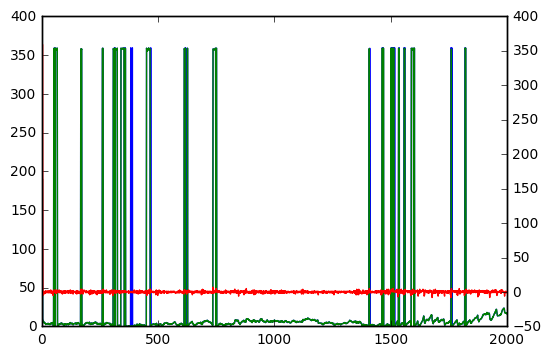

In [129]:
plt.plot(fly.orientations[1:2000])
plt.plot(angles[np.argmax(state_estimates,axis =1)])
plt.twinx()
plt.plot(velocities,color = 'r')
#plt.gca().set_xbound(1750,1800)
#plt.gca().set_xbound(1240,1350)